In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build the volcabulary of the characters and mapping to/from integers 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [142]:
# Build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context),'------>',itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [144]:
# Build the dataset
# Training split, dev/validation split, test split 
# 80%, 10%, 10%
# Training set: Used to optimize the parameters of the model
# Dev/ validation set: Used to development of all the hyperparameters of the model like size of the hidden layer, size of the embedding etc.
# test set: evaluate the performance of the model. You should test on test set few times otherwise you might end up overfitting to test set as well. 

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []

    for w in words:
    #     print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context),'------>',itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [80]:
# Create a look up table c to map the characters into a small 2 dimentional space, in the original paper then represented 17000 words in a 30 dimentional space
# This first look up part can be considered as a simple linear layer because the same look up can be obtained by doing vector multiplication (watch lecture at ~14 mins)
C = torch.randn((27,2))

emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [81]:
W1 = torch.randn((6, 100)) # We have 3 embeddings of 2 dimentions and we want 100 neurons
b1 = torch.randn(100)
h = torch.tanh((emb.view(-1,6) @ W1) + b1) # view is very efficient way of manipulating the shape 
print(h.shape)

torch.Size([228146, 100])


In [82]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [83]:
logits = (h @ W2) + b2
logits.shape

torch.Size([228146, 27])

In [84]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [85]:
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()
print(loss)

tensor(15.9867)


In [86]:
# Making it more structured 

In [145]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182437, 3]), torch.Size([182437]))

In [157]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [161]:
sum(p.nelement() for p in parameters) # Number of parameters in total

10281

In [162]:
for p in parameters:
    p.requires_grad = True

In [164]:
# This code is not training but finding the best learning rate to use
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lri = []
lossi = []
for i in range(1000):
    # Creating a mini batch 
    ix = torch.randint(0, X.shape[0], (32, ))
    # Forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # The following commented lines can be efficiently implemented using cross_entropy function
    # When you use cross_entropy Pytorch does not create new tensors like counts, prob, loss etc. It will cluster many operations using fused kernel. Backprop also becomes very efficient. 
    # Cross_entropy is also numerically more stable. Check the video to get deeper understanding.
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    #Track the stats
    lri.append(lre[i])
    lossi.append(loss.item())
print(loss.item())

13.68471622467041


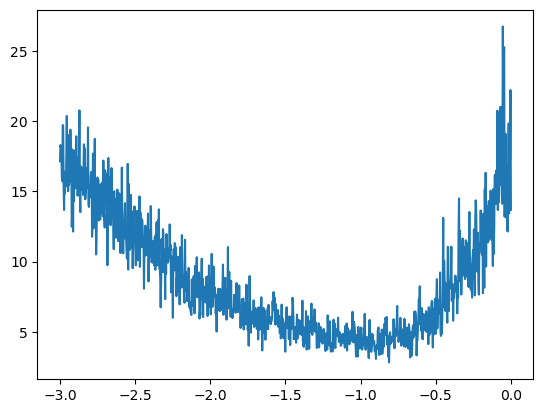

In [165]:
plt.plot(lri, lossi)

In [169]:
# so the good learning rate is 0.1
for _ in range(30000):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # The following commented lines can be efficiently implemented using cross_entropy function
    # When you use cross_entropy Pytorch does not create new tensors like counts, prob, loss etc. It will cluster many operations using fused kernel. Backprop also becomes very efficient. 
    # Cross_entropy is also numerically more stable. Check the video to get deeper understanding.
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1
    for p in parameters:
        p.data += -0.1 * p.grad
    
print(loss.item())

2.4009652137756348


In [170]:
# calculating the loss over the training set
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.4610595703125


In [171]:
# calculating the loss over the dev set
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4975643157958984


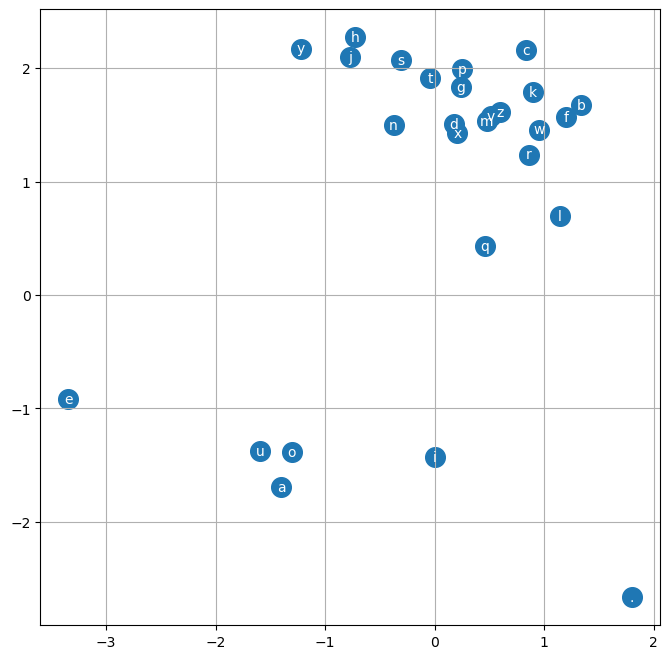

In [172]:
# It seems the the first embedding layer is a bottleneck in improving the performance of the model.
# Before we increase the size of the embedding layer, lets first visualize the embedding layer as it is 2D. 
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [176]:
# Increasing the size of embedding layer 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True
    
lri = []
lossi = []
stepi = []


Total parameters: 11897


In [206]:
for i in range(200000):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    # The following commented lines can be efficiently implemented using cross_entropy function
    # When you use cross_entropy Pytorch does not create new tensors like counts, prob, loss etc. It will cluster many operations using fused kernel. Backprop also becomes very efficient. 
    # Cross_entropy is also numerically more stable. Check the video to get deeper understanding.
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(loss.item())

2.2826929092407227


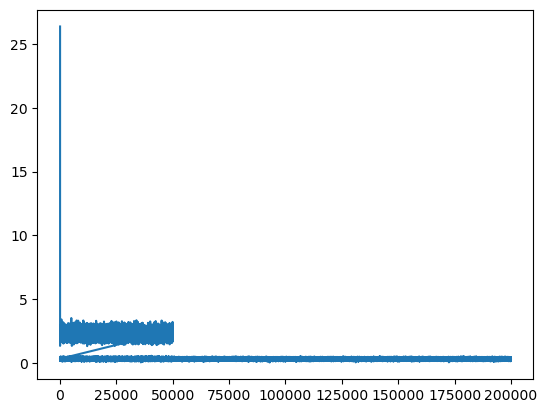

In [207]:
plt.plot(stepi, lossi)

In [208]:
# calculating the loss over the training set
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1699583530426025


In [209]:
# calculating the loss over the dev set
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.266592264175415


In [210]:
# Sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
        
        
        

carmanelle.
haritzimrithea.
lanna.
sanestronta.
amerynn.
areeianna.
sarickedin.
kaleja.
sham.
port.
quinten.
lilen.
vadiquinterra.
jaristini.
espirsa.
sed.
ediia.
gianahyariah.
saseonna.
ksya.
